In [1]:
import os
import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

from pandarallel import pandarallel
pandarallel.initialize(os.cpu_count()-1, progress_bar=True)

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [14]:
data = pd.read_csv('./dataset/7.email/email_table.csv')
email_open = pd.read_csv('./dataset/7.email/email_opened_table.csv') # open email
email_link = pd.read_csv('./dataset/7.email/link_clicked_table.csv') # open email and click link

In [15]:
email_open = set(email_open.to_numpy().flatten())
email_link = set(email_link.to_numpy().flatten())

In [16]:
inter = email_open.intersection(email_link)
len(email_open), len(email_link), len(inter)

(10345, 2119, 2069)

In [17]:
email_open = email_open | email_link

- some click link but not open email, possibly an engineering bug -> fix by if click=True, then open=True

In [18]:
data['open'] = data['email_id'].parallel_apply(lambda x: 1 if x in email_open else 0)
data['click'] = data['email_id'].parallel_apply(lambda x: 1 if x in email_link else 0)

In [19]:
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   email_id             100000 non-null  int64 
 1   email_text           100000 non-null  object
 2   email_version        100000 non-null  object
 3   hour                 100000 non-null  int64 
 4   weekday              100000 non-null  object
 5   user_country         100000 non-null  object
 6   user_past_purchases  100000 non-null  int64 
 7   open                 100000 non-null  int64 
 8   click                100000 non-null  int64 
dtypes: int64(5), object(4)
memory usage: 6.9+ MB


,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases,open,click
0,85120,short_email,personalized,2,Sunday,US,5,0,0
1,966622,long_email,personalized,12,Sunday,UK,2,1,1
2,777221,long_email,personalized,11,Wednesday,US,2,0,0
3,493711,short_email,generic,6,Monday,UK,1,0,0
4,106887,long_email,generic,14,Monday,US,6,0,0


In [43]:
data.describe()

,email_id,hour,user_past_purchases,open,click
count,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000
mean,498690.196160,9.059300,3.87845,0.103950,0.021190
std,289230.727534,4.439637,3.19611,0.305197,0.144018
min,8.000000,1.000000,0.00000,0.000000,0.000000
25%,246708.250000,6.000000,1.00000,0.000000,0.000000
50%,498447.000000,9.000000,3.00000,0.000000,0.000000
75%,749942.750000,12.000000,6.00000,0.000000,0.000000
max,999998.000000,24.000000,22.00000,1.000000,1.000000


In [33]:
display(data['open'].value_counts(normalize=True))
display(data['click'].value_counts(normalize=True))

open
0    0.89605
1    0.10395
Name: proportion, dtype: float64

click
0    0.97881
1    0.02119
Name: proportion, dtype: float64

- 10% open the email, 2% click the link

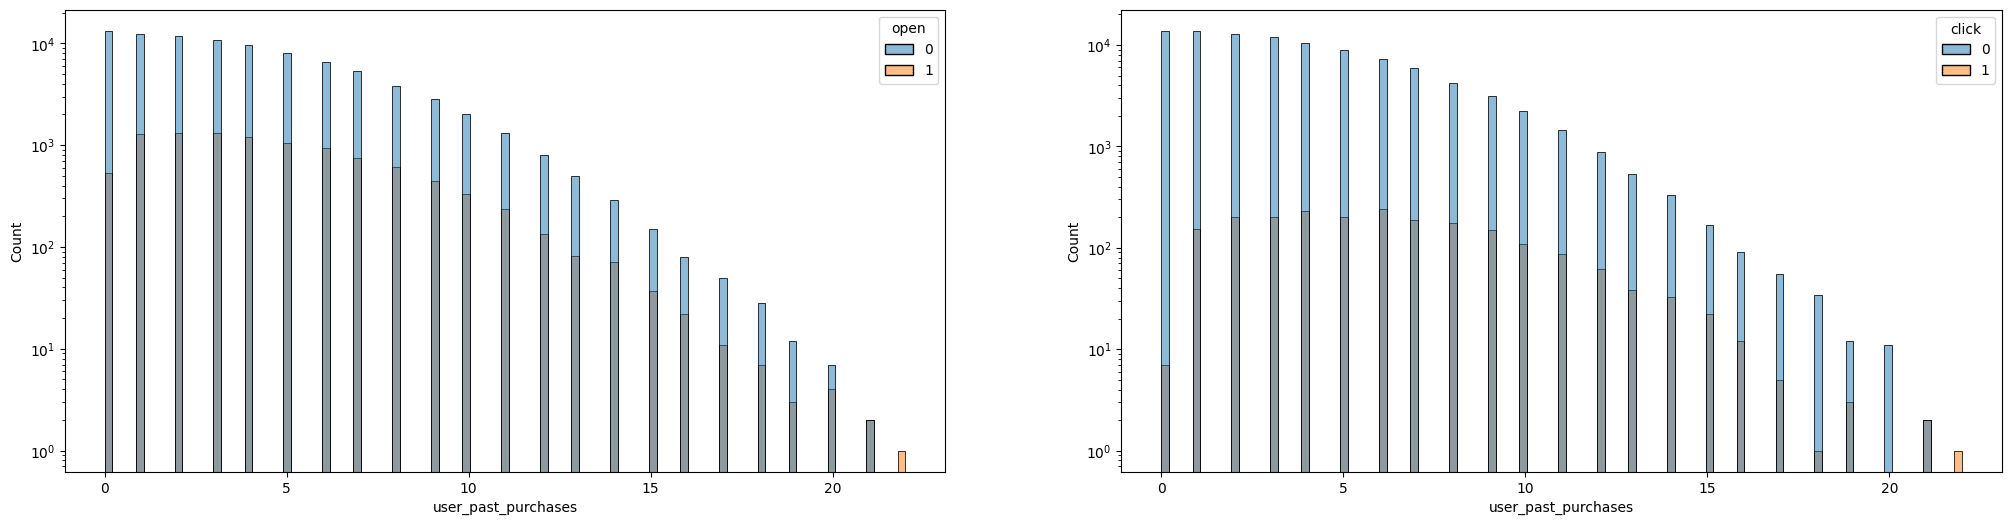

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(25, 6))
sns.histplot(data=data, x='user_past_purchases', hue='open', ax=ax[0]);
sns.histplot(data=data, x='user_past_purchases', hue='click', ax=ax[1]);
ax[0].set_yscale('log')
ax[1].set_yscale('log')

Text(0.5, 0, 'hour')

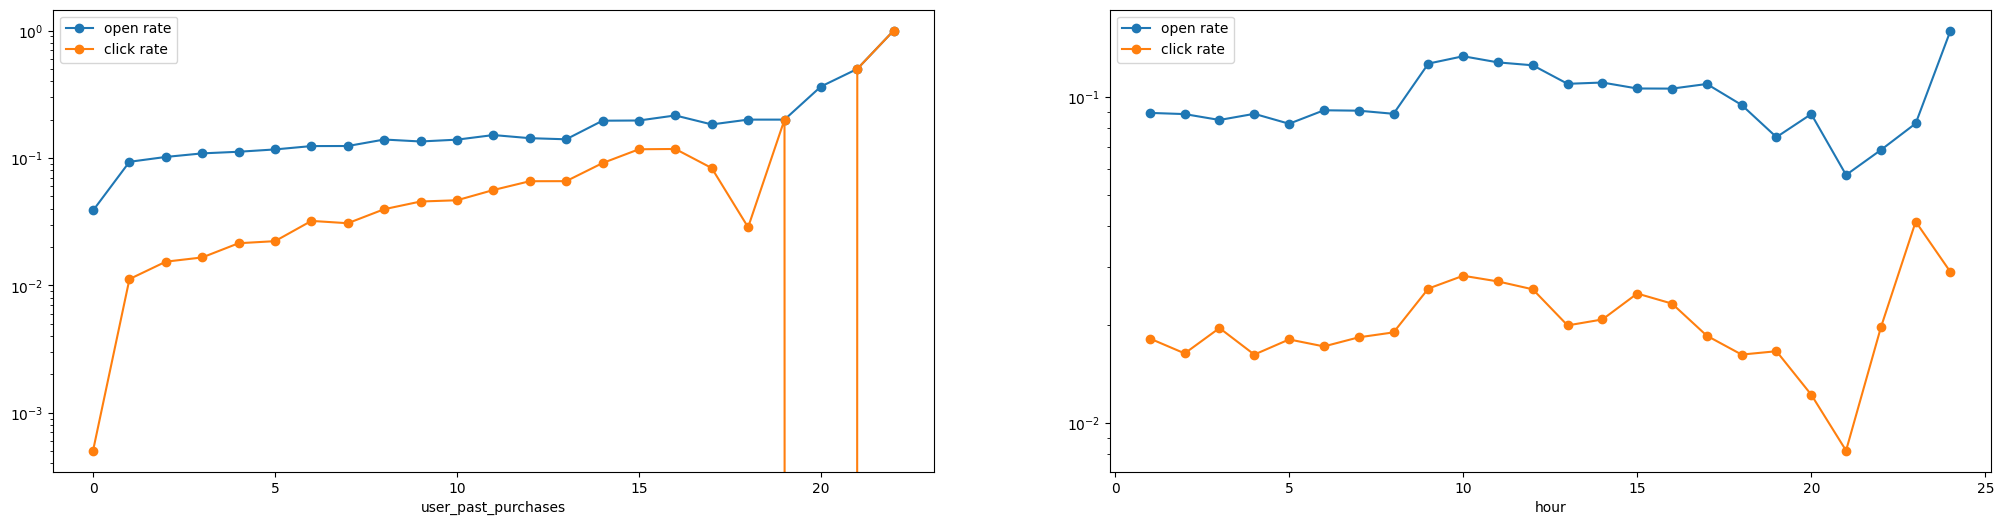

In [45]:
data_purchase = data.groupby('user_past_purchases')[['open', 'click']].mean()
data_hr = data.groupby('hour')[['open', 'click']].mean()
fig, ax = plt.subplots(1, 2, figsize=(25, 6))
ax[0].plot(data_purchase.index, data_purchase['open'], marker='o', label='open rate')
ax[0].plot(data_purchase.index, data_purchase['click'], marker='o', label='click rate')
ax[0].set_yscale('log')
ax[0].legend()
ax[0].set_xlabel('user_past_purchases')
ax[1].plot(data_hr.index, data_hr['open'], marker='o', label='open rate')
ax[1].plot(data_hr.index, data_hr['click'], marker='o', label='click rate')
ax[1].set_yscale('log')
ax[1].legend()
ax[1].set_xlabel('hour')

<Axes: xlabel='user_country', ylabel='count'>

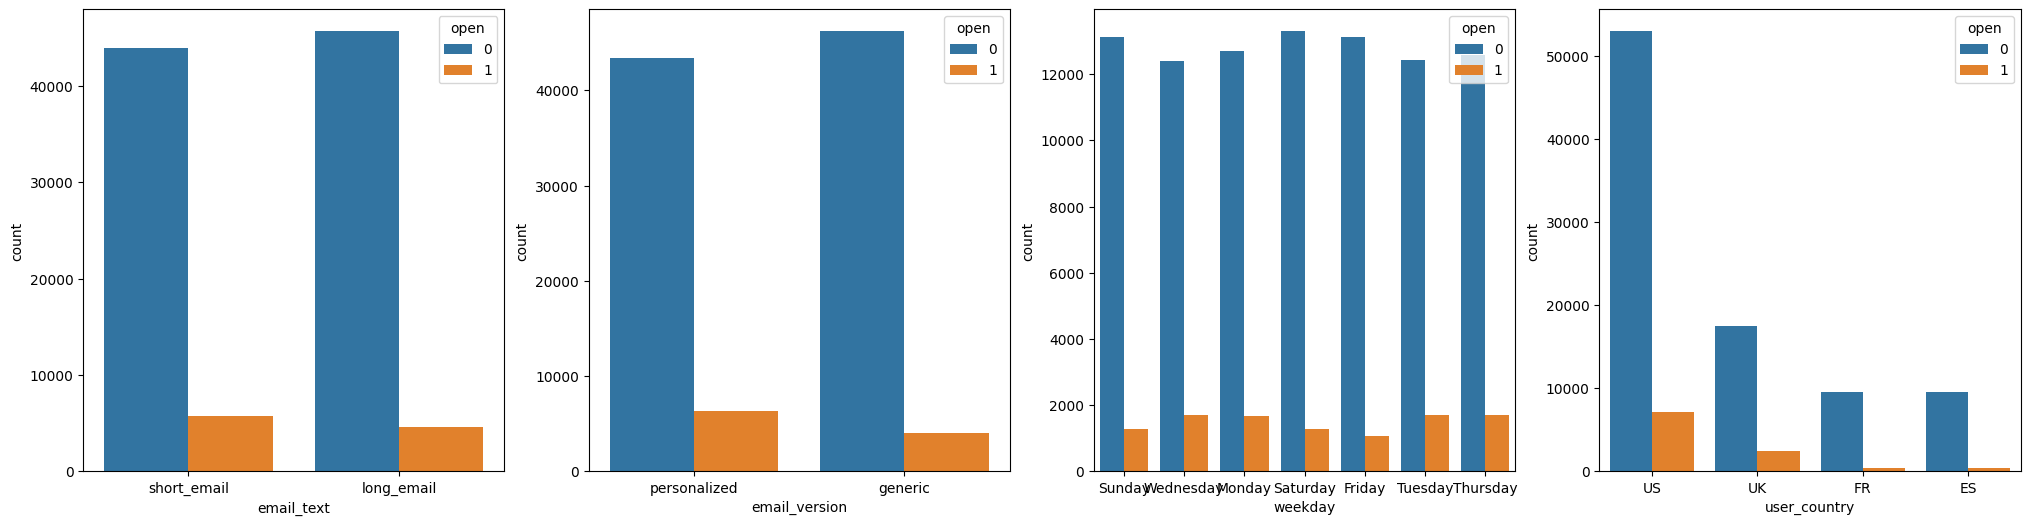

In [46]:
fig, ax = plt.subplots(1, 4, figsize=(25, 6))
sns.countplot(x='email_text', hue='open', data=data, ax=ax[0])
sns.countplot(x='email_version', hue='open', data=data, ax=ax[1])
sns.countplot(x='weekday', hue='open', data=data, ax=ax[2])
sns.countplot(x='user_country', hue='open', data=data, ax=ax[3])

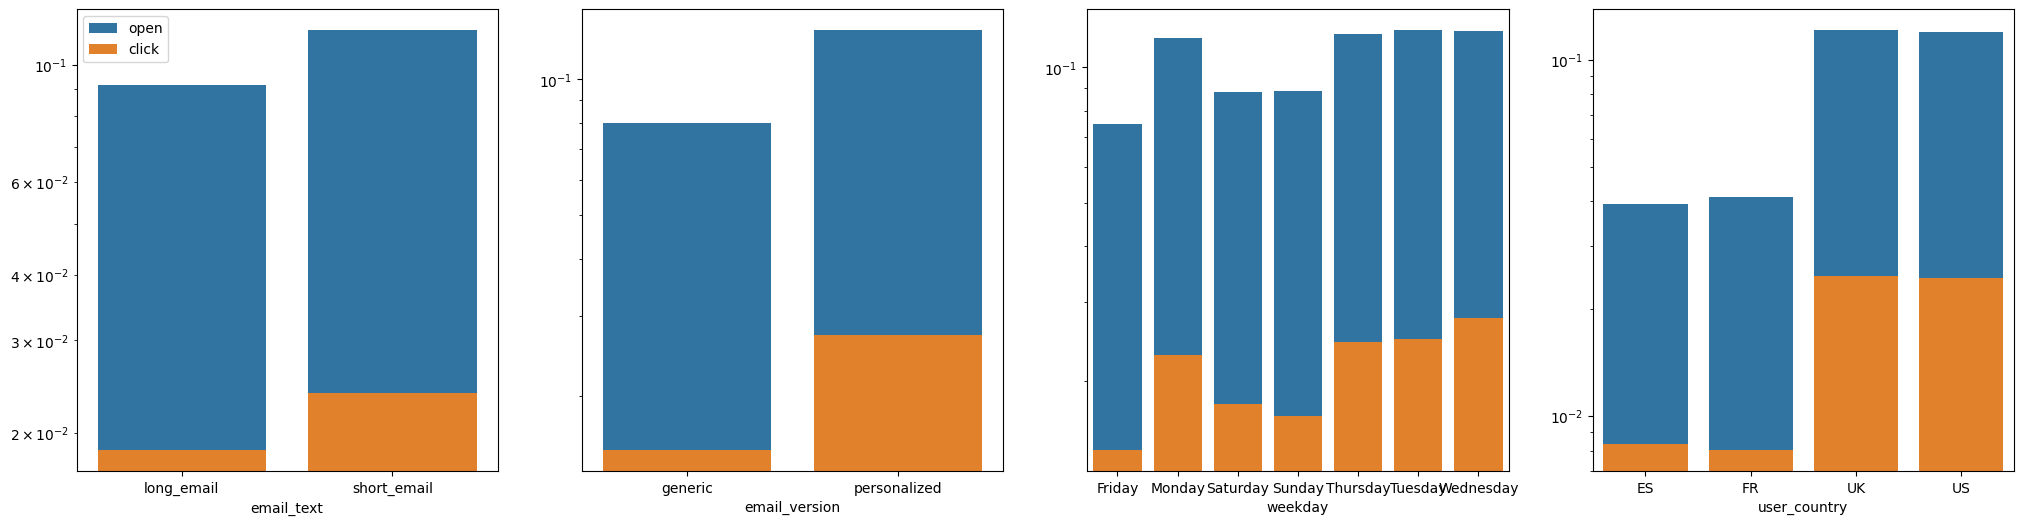

In [51]:
data_etext = data.groupby('email_text')[['open', 'click']].mean()
data_ever = data.groupby('email_version')[['open', 'click']].mean()
data_weekday = data.groupby('weekday')[['open', 'click']].mean()
data_country = data.groupby('user_country')[['open', 'click']].mean()

# user seaborn to plot
fig, ax = plt.subplots(1, 4, figsize=(25, 6))
sns.barplot(x=data_etext.index, y='open', data=data_etext, ax=ax[0], label='open')
sns.barplot(x=data_etext.index, y='click', data=data_etext, ax=ax[0], label='click')
sns.barplot(x=data_ever.index, y='open', data=data_ever, ax=ax[1])
sns.barplot(x=data_ever.index, y='click', data=data_ever, ax=ax[1])
sns.barplot(x=data_weekday.index, y='open', data=data_weekday, ax=ax[2])
sns.barplot(x=data_weekday.index, y='click', data=data_weekday, ax=ax[2])
sns.barplot(x=data_country.index, y='open', data=data_country, ax=ax[3])
sns.barplot(x=data_country.index, y='click', data=data_country, ax=ax[3])
plt.setp(ax, yscale='log');
plt.setp(ax, ylabel=None);
ax[0].legend()

- short email is a little bit better than long email
- personalized is better than generic
- Mon-Thu > Sat,Sun > Fri
- UK,US > ES,FR

In [52]:
data.head()

,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases,open,click
0,85120,short_email,personalized,2,Sunday,US,5,0,0
1,966622,long_email,personalized,12,Sunday,UK,2,1,1
2,777221,long_email,personalized,11,Wednesday,US,2,0,0
3,493711,short_email,generic,6,Monday,UK,1,0,0
4,106887,long_email,generic,14,Monday,US,6,0,0


In [56]:
import calendar
data_cor = data.copy()
data_cor.drop(columns=['email_id', 'user_country'], inplace=True)
data_cor['email_text'] = data_cor['email_text'].parallel_apply(lambda x: 1 if x == 'long_email' else 0)
data_cor['email_version'] = data_cor['email_version'].parallel_apply(lambda x: 1 if x == 'personalized' else 0)

days = dict(zip(calendar.day_name, range(7))) # Monday is 0, Sunday is 6
data_cor['weekday'] = data_cor['weekday'].parallel_apply(lambda x: days[x])

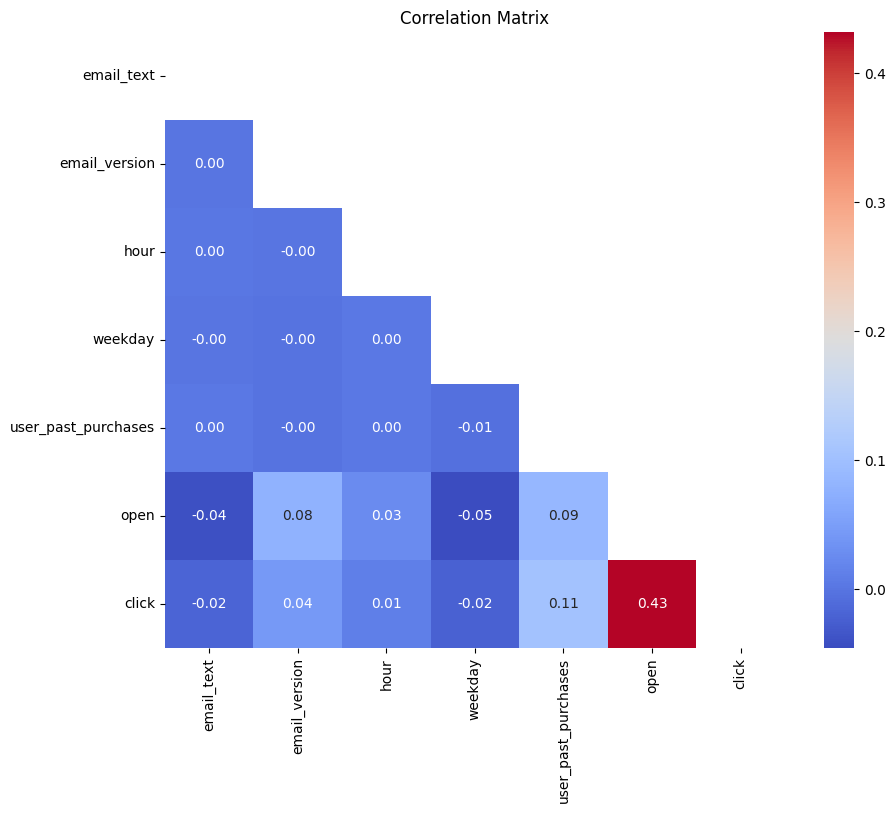

In [58]:
# plot correlation matrix
corr = data_cor.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(10, 8))
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

Thus the improvements are
- keep email short
- send personalized email
- send on weekday (excl Friday)
- focus on UK and US users